In [120]:
'''
This file takes the EOMs and applies an S curve to simulate
cable motion, it will also apply input shaping to the model and plot the two
responses.
'''

from scipy.integrate import odeint
import numpy as np
from numpy import sin, cos, sqrt
import seaborn as sns
sns.set_context("talk", font_scale=1.2)
import matplotlib.pyplot as plt
import InputShaping as shaping
%matplotlib inline


####### Variables to Change ##############

# Beginning Point
X_begin = 16.0
Y_begin = 13.0

# Ending Point
X_end = 10.0
Y_end = 7.5

# Time to get to Point
Risetime = 3.0

# Time to start Moving
time_begin = 1.0

# Mass
mass = 1.0

# K of Cables
cable_K = 10.0

# C of Cables
cable_C = 1.0

# K of Rod
rod_K = 10.0

# C of Rod
rod_C = 1.0

# Length of Rod
rod_length = 3.0

# Time to plot response
endtime = 20.0
#########################################

inertia = rod_length**2 * (1.0/3.0) * mass

def Lengths(x,y):
    k=10
    h=20
    m=1.0
    Fy = np.array([[k*y/np.sqrt(x**2 + y**2), k*y/np.sqrt(y**2 + (h - x)**2)],
                   [k*x/np.sqrt(x**2 + y**2), -h*k/np.sqrt(y**2 + (h - x)**2
                    )+k*x/np.sqrt(y**2 + (h - x)**2)]])
    a = np.array([2*k*y - 9.81*m,-h*k + 2*k*x])
    x = np.linalg.solve(Fy,a)
    return x

L1_begin, L2_begin = Lengths(X_begin, Y_begin)
L1_end, L2_end = Lengths(X_end, Y_end)



def eq_of_motion(w, t, p):
    """
    Defines the differential equations for a planer CDPM.

    Arguments:
        w :  vector of the state variables:
                  w = [x, y, b, x_dot, y_dot, b_dot]
        t :  time
        p :  vector of the parameters:
                  p = [m, k, g, H, c, D, t, Izz, k_beta, c_beta(w, t, p), L_1_init,
                       L_2_init]

    Returns:
        sysODE : An list representing the system of equations of motion
                 as 1st order ODEs
    """
    x, y, b, x_dot, y_dot, beta_dot = w
    m, k, g, H, c, D, Izz, k_beta,c0, Begin1, Begin2,  Amp1, Amp2, RiseTime, StartTime, Shaper = p

    # Create sysODE = (x', theta', x_dot', theta_dot'):
    sysODE = [x_dot,
              y_dot,
              beta_dot,
              (D*beta_dot**2*m*sin(b)/2 - D*m*(-D*g*m*sin(b)/2 - D*(D*beta_dot**2*m*sin(b)/2 - c*x*(x_dot + y_dot)/sqrt(x**2 + y**2) + c*(H - x)*(-x_dot + y_dot)/sqrt(y**2 + (H - x)**2) - 1.0*k*x*(-L_1_init(t, p) + sqrt(x**2 + y**2))/sqrt(x**2 + y**2) - 1.0*k*(-H + x)*(-L_2_init(t, p) + sqrt(y**2 + (H - x)**2))/sqrt(y**2 + (H - x)**2))*cos(b)/2 - D*(-D*beta_dot**2*m*cos(b)/2 - c*y*(-x_dot + y_dot)/sqrt(y**2 + (H - x)**2) - c*y*(x_dot + y_dot)/sqrt(x**2 + y**2) + g*m - 1.0*k*y*(-L_1_init(t, p) + sqrt(x**2 + y**2))/sqrt(x**2 + y**2) - 1.0*k*y*(-L_2_init(t, p) + sqrt(y**2 + (H - x)**2))/sqrt(y**2 + (H - x)**2))*sin(b)/2 - 1.0*b*k_beta - beta_dot*c_beta(w, t, p) - m*(-D*beta_dot*x_dot*sin(b)/2 + D*beta_dot*y_dot*cos(b)/2 + D*(-beta_dot*x_dot*sin(b) + beta_dot*y_dot*cos(b))/2)/2 + m*(-D*beta_dot*x_dot*sin(b)/2 + D*beta_dot*y_dot*cos(b)/2 + D*beta_dot*(-x_dot*sin(b) + y_dot*cos(b))/2)/2)*cos(b)/(2*(-D**2*m*sin(b)**2/4 - D**2*m*cos(b)**2/4 + D**2*m/4 + Izz)) - c*x*(x_dot + y_dot)/sqrt(x**2 + y**2) + c*(H - x)*(-x_dot + y_dot)/sqrt(y**2 + (H - x)**2) - 1.0*k*x*(-L_1_init(t, p) + sqrt(x**2 + y**2))/sqrt(x**2 + y**2) - 1.0*k*(-H + x)*(-L_2_init(t, p) + sqrt(y**2 + (H - x)**2))/sqrt(y**2 + (H - x)**2))/m,
              (-D*beta_dot**2*m*cos(b)/2 - D*m*(-D*g*m*sin(b)/2 - D*(D*beta_dot**2*m*sin(b)/2 - c*x*(x_dot + y_dot)/sqrt(x**2 + y**2) + c*(H - x)*(-x_dot + y_dot)/sqrt(y**2 + (H - x)**2) - 1.0*k*x*(-L_1_init(t, p) + sqrt(x**2 + y**2))/sqrt(x**2 + y**2) - 1.0*k*(-H + x)*(-L_2_init(t, p) + sqrt(y**2 + (H - x)**2))/sqrt(y**2 + (H - x)**2))*cos(b)/2 - D*(-D*beta_dot**2*m*cos(b)/2 - c*y*(-x_dot + y_dot)/sqrt(y**2 + (H - x)**2) - c*y*(x_dot + y_dot)/sqrt(x**2 + y**2) + g*m - 1.0*k*y*(-L_1_init(t, p) + sqrt(x**2 + y**2))/sqrt(x**2 + y**2) - 1.0*k*y*(-L_2_init(t, p) + sqrt(y**2 + (H - x)**2))/sqrt(y**2 + (H - x)**2))*sin(b)/2 - 1.0*b*k_beta - beta_dot*c_beta(w, t, p) - m*(-D*beta_dot*x_dot*sin(b)/2 + D*beta_dot*y_dot*cos(b)/2 + D*(-beta_dot*x_dot*sin(b) + beta_dot*y_dot*cos(b))/2)/2 + m*(-D*beta_dot*x_dot*sin(b)/2 + D*beta_dot*y_dot*cos(b)/2 + D*beta_dot*(-x_dot*sin(b) + y_dot*cos(b))/2)/2)*sin(b)/(2*(-D**2*m*sin(b)**2/4 - D**2*m*cos(b)**2/4 + D**2*m/4 + Izz)) - c*y*(-x_dot + y_dot)/sqrt(y**2 + (H - x)**2) - c*y*(x_dot + y_dot)/sqrt(x**2 + y**2) + g*m - 1.0*k*y*(-L_1_init(t, p) + sqrt(x**2 + y**2))/sqrt(x**2 + y**2) - 1.0*k*y*(-L_2_init(t, p) + sqrt(y**2 + (H - x)**2))/sqrt(y**2 + (H - x)**2))/m,
              (-D*g*m*sin(b)/2 - D*(D*beta_dot**2*m*sin(b)/2 - c*x*(x_dot + y_dot)/sqrt(x**2 + y**2) + c*(H - x)*(-x_dot + y_dot)/sqrt(y**2 + (H - x)**2) - 1.0*k*x*(-L_1_init(t, p) + sqrt(x**2 + y**2))/sqrt(x**2 + y**2) - 1.0*k*(-H + x)*(-L_2_init(t, p) + sqrt(y**2 + (H - x)**2))/sqrt(y**2 + (H - x)**2))*cos(b)/2 - D*(-D*beta_dot**2*m*cos(b)/2 - c*y*(-x_dot + y_dot)/sqrt(y**2 + (H - x)**2) - c*y*(x_dot + y_dot)/sqrt(x**2 + y**2) + g*m - 1.0*k*y*(-L_1_init(t, p) + sqrt(x**2 + y**2))/sqrt(x**2 + y**2) - 1.0*k*y*(-L_2_init(t, p) + sqrt(y**2 + (H - x)**2))/sqrt(y**2 + (H - x)**2))*sin(b)/2 - 1.0*b*k_beta - beta_dot*c_beta(w, t, p) - m*(-D*beta_dot*x_dot*sin(b)/2 + D*beta_dot*y_dot*cos(b)/2 + D*(-beta_dot*x_dot*sin(b) + beta_dot*y_dot*cos(b))/2)/2 + m*(-D*beta_dot*x_dot*sin(b)/2 + D*beta_dot*y_dot*cos(b)/2 + D*beta_dot*(-x_dot*sin(b) + y_dot*cos(b))/2)/2)/(-D**2*m*sin(b)**2/4 - D**2*m*cos(b)**2/4 + D**2*m/4 + Izz)
              ]
    return sysODE


def L_1_init(t, p):
    """
    Defines the Length 1 input to the system.

    Arguments:
        t : current time step
        p : vector of parameters
    """
    m, k, g, H, c, D, Izz, k_beta,c0, Begin1, Begin2, Amp1, Amp2, RiseTime, StartTime, Shaper = p

    if Shaper == []:
        L_1_init = s_curve(t, Begin1, Amp1, RiseTime, StartTime)
    else:
        L_1_init = shaping.shaped_input(s_curve, t, Shaper, Begin1, Amp1, RiseTime,
                                        StartTime)
    return L_1_init


def L_2_init(t, p):
    """
    Defines the Length 2 input to the system.

    Arguments:
        t : current time step
        p : vector of parameters
    """
    m, k, g, H, c, D, Izz, k_beta,c0, Begin1, Begin2, Amp1, Amp2, RiseTime, StartTime, Shaper = p

    if Shaper == []:
        L_2_init = s_curve(t, Begin2, Amp2, RiseTime, StartTime)
    else:
        L_2_init = shaping.shaped_input(s_curve, t, Shaper, Begin2, Amp2, RiseTime,
                                        StartTime)
    return L_2_init


def s_curve(CurrTime, Begin, Amp, RiseTime, StartTime):
    """
    This was copied from Dr. Vaughan's Input shaping Library
    I edited it to allow for a beginning value.

    Function to generate an s-curve command

    Arguments:
      CurrTime : The current timestep or an array of times
      Amp : The magnitude of the s-curve (or final setpoint)
      RiseTime : The rise time of the curve
      StartTime : The time that the command should StartTime
      Begin : The beginning value

    Returns :
      The command at the current timestep or an array representing the command
      over the times given (if CurrTime was an array)
    """

    Amp = Amp - Begin

    scurve = 2.0 * ((CurrTime - StartTime)/RiseTime)**2 * (CurrTime-StartTime >=
             0) * (CurrTime-StartTime < RiseTime/2) + (-2.0 * ((CurrTime -
             StartTime)/RiseTime)**2 + 4.0 * ((CurrTime - StartTime) /RiseTime)
             - 1.0) * (CurrTime-StartTime >= RiseTime/2) * (CurrTime-StartTime <
             RiseTime) + 1.0 * (CurrTime-StartTime >= RiseTime)

    return (Amp * scurve) + Begin

def c_beta(w, t, p):
    ''' Defines the damping coefficient 
    
    Arguments:
        w :  vector of the state variables:
        t :  time
        p :  vector of the parameters:
    
    Returns:
        c : damping coeffient for the current time, t, and system state, w
    
    '''
    
    # Unpack the variables
    x, y, b, x_dot, y_dot, beta_dot = w
    m, k, g, H, c, D, Izz, k_beta,c0, Begin1, Begin2, Amp1, Amp2, RiseTime, StartTime, Shaper = p
    
    #return c0 # Just using the nominal, constant value right now
    
    c_sky = 50*c0
    
    # Continuous SkyHook
#     if x_dot * (x_dot - y_dot) >= 0:
#         if np.abs(y_dot - x_dot) > 1e-3:
#             if Shaper is None:
# #                 c_semiActive =  np.max([c0, np.min([c_sky * x_dot / np.max([(y_dot - x_dot),1e-3]), 10*c0])])
#                 c_semiActive =  np.max([0.0, np.min([c_sky * x_dot / (y_dot - x_dot), 10*c0])])
#             elif (np.abs(y_dot) < 1e-2):
#                 c_semiActive =  np.max([0.0, np.min([c_sky * x_dot / (y_dot - x_dot), 10*c0])])
#             else:
#                 c_semiActive = c0
#         else:
#             if Shaper is None:
# #                 c_semiActive =  np.max([c0, np.min([c_sky * x_dot / np.max([(y_dot - x_dot),1e-3]), 10*c0])])
#                 c_semiActive =  np.max([0.0, np.min([c_sky * np.sign(x_dot) * x_dot / 1e-6, 10*c0])])
#             elif (np.abs(y_dot) < 1e-2):
#                 c_semiActive =  np.max([0.0, np.min([c_sky * np.sign(x_dot) * x_dot / 1e-6, 10*c0])])
#             else:
#                 c_semiActive = c0
#     else:
#         c_semiActive = 0.0

#     # On-Off Skyhook Damping
#     if x_dot * (x_dot - y_dot) >= 0.0:
#         if Shaper is None:
#             c_semiActive = 3.0 * c0
#         elif (np.abs(y_dot) < 1e-2):
#             c_semiActive = 3.0 * c0
#         else:
#             c_semiActive = 0.0
#     else:
#         c_semiActive = 0.0

#     if beta_dot >= 0.0:
#         if Shaper is None:
#             c_semiActive = 3.0 * c0
#         elif (np.abs(beta_dot) < 1e-2):
#             c_semiActive = 3.0 * c0
#         else:
#             c_semiActive = 0.0
#     else:
#         c_semiActive = 0.0


#     # Adaptive Passive Damping
    if x_dot * (x_dot - y_dot) >= 0:
        c_semiActive = 2.0 * c0
    else:
        c_semiActive = c0

#     if b * beta_dot >= 0:
#         c_semiActive = 2.0 * c0
#     else:
#         c_semiActive = c0

#     # On-off Balanace Control
#     if (x - y) * (x_dot - y_dot) <= 0.0:
#         c_semiActive = 4*c0
#     else:
#         c_semiActive = c0

#     # Continuous Balance Control
#     if (x - y) * (x_dot - y_dot) <= 0.0:
#         c_semiActive = -k * (y - x) / (np.max([np.abs(y_dot - x_dot), 1e-6]) * np.sign(y_dot - x_dot))
#     else:
#         c_semiActive = 0.0
    
    
#     # No damping
#     c_semiActive = 1.0
    
    return c_semiActive


################## Various Shapers ######################################

# Going with 500rpm
# example_shaper = shaping.EI_3mode(0.2593206987035489, 0.017766920997407218,
#                                   0.4756421924129393, 0.20371676657418006,
#                                   0.7802304334889989, 0.251892133943285)
# example_shaper = shaping.EI_2mode(0.7802304334889989, 0.251892133943285,
#                                   0.2593206987035489, 0.017766920997407218)
# example_shaper = shaping.ZV(0.2593206987035489, 0.017766920997407218)
example_shaper = shaping.ZV_EI_2mode(0.2593206987035489, 0.017766920997407218, 0.47558317356, 0.203271432775)
# example_shaper = shaping.UMZVD(0.25946057132, 0.00869237035333, 0.47558317356, 0.203271432775)
# example_shaper = shaping.ZVD_2mode(0.25946057132, 0.00869237035333, 0.47558317356, 0.203271432775)
# example_shaper = shaping.EI(0.2593206987035489, 0.017766920997407218)
#########################################################################


# ODE solver parameters
abserr = 1.0e-9
relerr = 1.0e-9
max_step = 0.01
numpoints = 1000

# Create the time samples for the output of the ODE solver
t = np.linspace(0.0, endtime, numpoints)

# Set up simulation parameters
# m = 1.0
# k = 10.0
g = 9.81
H = 20.0
# c0=0.0
# c = 1.0
# D = 1.0
# Izz = 1
# k_beta = 1.0
# c_beta(w, t, p) = 0.01
# L_1_init = s_curve(t, 15.62, 25.0, 4.0, 3.0)
# L_2_init = s_curve(t, 15.62, 20.61, 4.0, 3.0)


# Initial conditions
# x_init = 10.0                        # initial position
x_dot_init = 0.0                    # initial velocity
# y_init = 12.0                   # initial angle
y_dot_init = 0.0                # initial angular velocity
beta_init = 0.0                        # initial position
beta_dot_init = 0.0

# Set up the parameters for the input function
# Begin1 = 15.62               # Initial Length 1 of Cable (m)
# Begin2 = 15.62               # Initial Length 2 of Cable (m)
# Amp1 = 25.0                  # Final Cable 1 Length (m)
# Amp2 = 20.61                 # Final Cable 2 Length(m)
# StartTime = 3.0              # Time the cables will start moving (s)
# RiseTime = 4.0               # Time for to move to takes (s)
Shaper = []

In [125]:
# Pack the parameters and initial conditions into arrays
p = [mass, cable_K, g, H, cable_C, rod_length, inertia, rod_K,3.0, L1_begin, L2_begin, L1_end, L2_end,
     Risetime, time_begin, example_shaper.shaper]

p1 = [mass, cable_K, g, H, cable_C, rod_length, inertia, rod_K,3.0, L1_begin, L2_begin, L1_end, L2_end,
     Risetime, time_begin, Shaper]

x0 = [X_begin, Y_begin, beta_init, x_dot_init, y_dot_init, beta_dot_init]

resp1 = odeint(eq_of_motion, x0, t, args=(p1,), atol=abserr, rtol=relerr, hmax=max_step)

resp = odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr, hmax=max_step)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:113: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:131: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


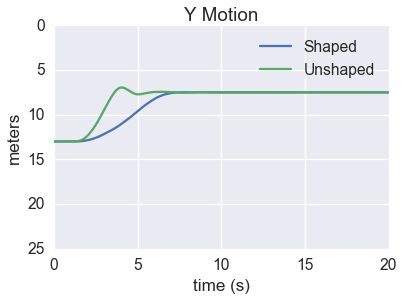

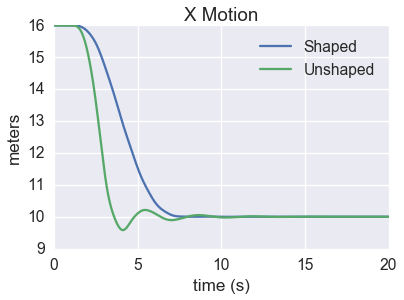

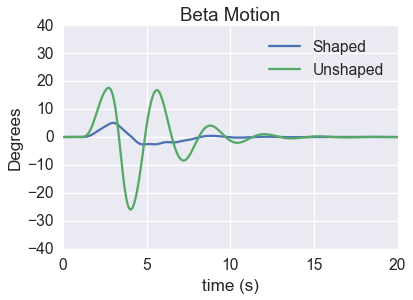

In [126]:
# np.savetxt("response.csv", resp1, delimiter=",")
# np.savetxt("sim_time.csv", t, delimiter=",")
# np.savetxt("response_s.csv", resp, delimiter=",")

########### PLOTTING #####################

plt.figure(0)
# plt.subplot(211)
plt.plot(t, resp[:,1], label='Shaped')
plt.plot(t, resp1[:,1], label='Unshaped')
plt.ylim(25,0)
plt.legend()
plt.title('Y Motion')
plt.xlabel('time (s)')
plt.ylabel('meters')
plt.show()

plt.figure(1)
plt.plot(t, resp[:,0], label='Shaped')
plt.plot(t, resp1[:,0], label='Unshaped')
plt.legend()
plt.title('X Motion')
plt.xlabel('time (s)')
plt.ylabel('meters')
plt.show()

plt.figure(2)
plt.plot(t, np.degrees(resp[:,2]), label='Shaped')
plt.plot(t, np.degrees(resp1[:,2]), label='Unshaped')
plt.legend()
plt.ylim(-40,40)
# plt.xlim(0,60)
plt.title('Beta Motion')
plt.xlabel('time (s)')
plt.ylabel('Degrees')
plt.savefig("Beta_Motion.pdf")
plt.show()